#### We are going to be using the LeNet model for convolution.

#### The Preprocessing steps are identical to the MNIST classification Model through fully connected layers.

#### Importing Libraries and Data Preprocessing.

In [1]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn 
import torch.nn.functional as F 

In [3]:
transform_train = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
training_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

training_loader = DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def im_convert(ten):
    image =ten.clone().detach().numpy()
    image = image.transpose(1,2,0)# Original (color, width, height) new (width, height, color)
    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5,0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [5]:
classes = ('plane', 'cars', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


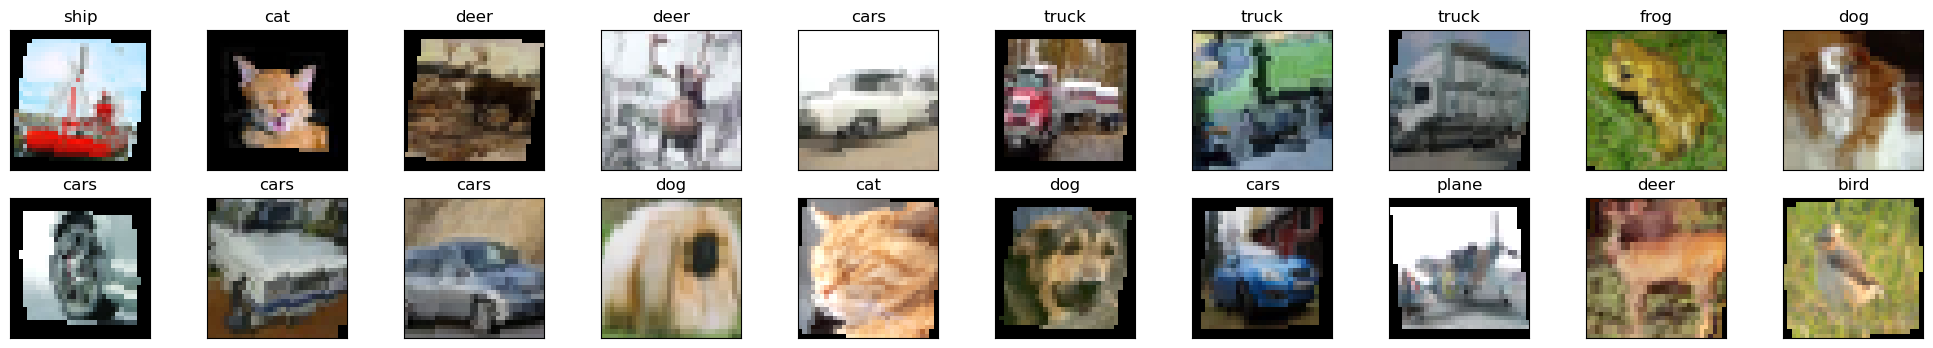

In [6]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx].item()])


#### Model and Training.

In [7]:
class LeNet(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # Try kernel size 10
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(in_features=4*4*64, out_features=500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=500, out_features=10)

    def forward(self, x):
        # x = x.view(100, 28, 28)
        # x = x.view(28, 28, 100)
        # x = x.unsqueeze(0)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,1), 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,1), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,1), 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x)) 
        x = self.dropout1(x)
        x = self.fc2(x) # try softmax activation
        return x 

In [8]:
model = LeNet()
model 

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

#### The training process is also identical.

In [10]:
# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Choose the appropriate GPU device
else:
    device = torch.device("cpu")     # Use CPU if GPU is not available

# Assuming you've defined and initialized model, criterion, and optimizer
model = model.to(device)  # Move the model to the GPU or CPU

epochs = 18
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []


for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    model.train()  # Set the model to training mode

    for inputs, labels in training_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU or CPU.
        # inputs = inputs.view(inputs.shape[0], -1)
        # print(inputs.shape)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)


        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('Epoch [{}/{}], Training Loss: {:.4f}, Acc: {:.4f}'
              .format(e + 1, epochs, epoch_loss, epoch_acc.item()))
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Acc: {:.4f}'
              .format(e + 1, epochs, val_epoch_loss, val_epoch_acc.item()))


# You can add a validation loop here to evaluate the model's performance on a validation dataset after each epoch


/home/areeb/anaconda3/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch [1/18], Training Loss: 1.7084, Acc: 37.2540
Epoch [1/18], Validation Loss: 1.3865, Validation Acc: 49.3900
Epoch [2/18], Training Loss: 1.4376, Acc: 47.9980
Epoch [2/18], Validation Loss: 1.2712, Validation Acc: 53.7400
Epoch [3/18], Training Loss: 1.3476, Acc: 51.4280
Epoch [3/18], Validation Loss: 1.1884, Validation Acc: 57.2400
Epoch [4/18], Training Loss: 1.2740, Acc: 54.4860
Epoch [4/18], Validation Loss: 1.1452, Validation Acc: 58.8300
Epoch [5/18], Training Loss: 1.2094, Acc: 56.6760
Epoch [5/18], Validation Loss: 1.0704, Validation Acc: 61.6100
Epoch [6/18], Training Loss: 1.1666, Acc: 58.4220
Epoch [6/18], Validation Loss: 1.0313, Validation Acc: 63.4400
Epoch [7/18], Training Loss: 1.1239, Acc: 59.8100
Epoch [7/18], Validation Loss: 0.9871, Validation Acc: 65.1000
Epoch [8/18], Training Loss: 1.0917, Acc: 61.1780
Epoch [8/18], Validation Loss: 0.9619, Validation Acc: 65.6400
Epoch [9/18], Training Loss: 1.0582, Acc: 62.5360
Epoch [9/18], Validation Loss: 0.9308, Validat

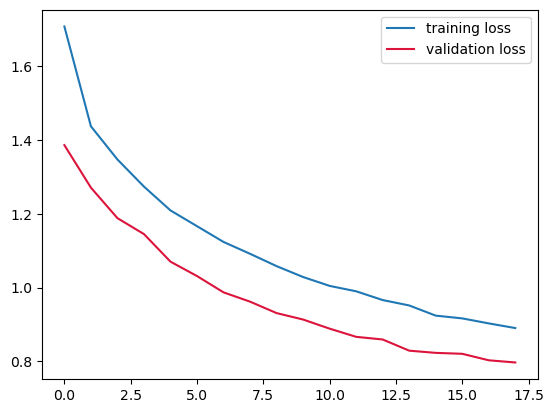

In [20]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label = "validation loss", c="crimson")
plt.legend()

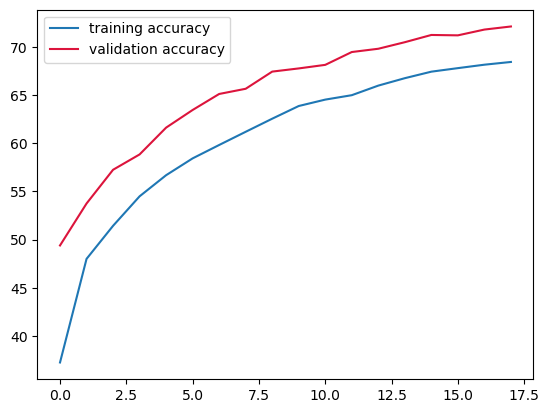

In [12]:
plt.plot([c.cpu().detach().numpy() for c in running_corrects_history], label='training accuracy')
plt.plot([c.cpu().detach().numpy() for c in val_running_corrects_history], label = "validation accuracy", c="crimson")
plt.legend()

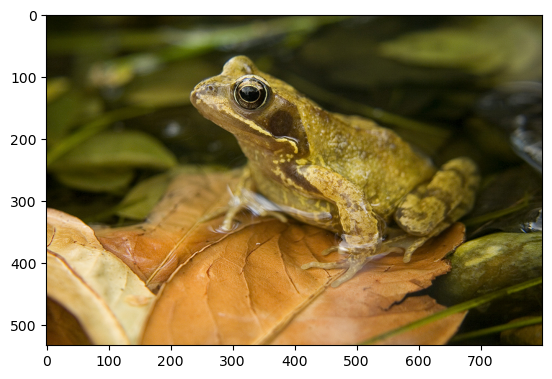

In [13]:
url_for_test_image = r'https://static.wikia.nocookie.net/naturerules1/images/f/f0/Common-Frog.jpg/revision/latest?cb=20210126150954'
import requests
from PIL import Image, ImageOps
response = requests.get(url_for_test_image, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

(32, 32, 3)


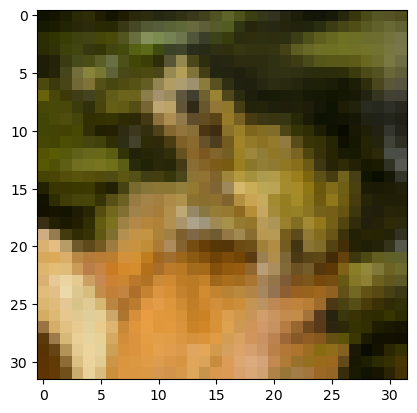

In [14]:
# img = ImageOps.invert(img)
# img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [15]:
image = img.to(device)
# image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


(32, 32, 3)
deer


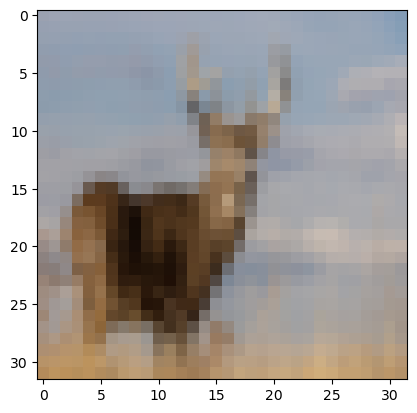

In [16]:
deer_url = r'https://t3.ftcdn.net/jpg/04/78/15/66/360_F_478156667_g5HWuxaovhGb7BGdawZiYUMJEOcyQwdO.jpg'
response = requests.get(deer_url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
img = transform(img)
plt.imshow(im_convert(img))
image = img.to(device)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

In [17]:
def image_tester(img_url):
    response = requests.get(img_url, stream=True)
    img = Image.open(response.raw)
    img = ImageOps.invert(img)
    img = img.convert('1')
    img = transform(img)
    plt.imshow(im_convert(img), cmap='gray')
    images = img.to(device)
    image = images[0].unsqueeze(0).unsqueeze(0)
    output = model(image)
    _, pred = torch.max(output, 1)
    print(pred.item())

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


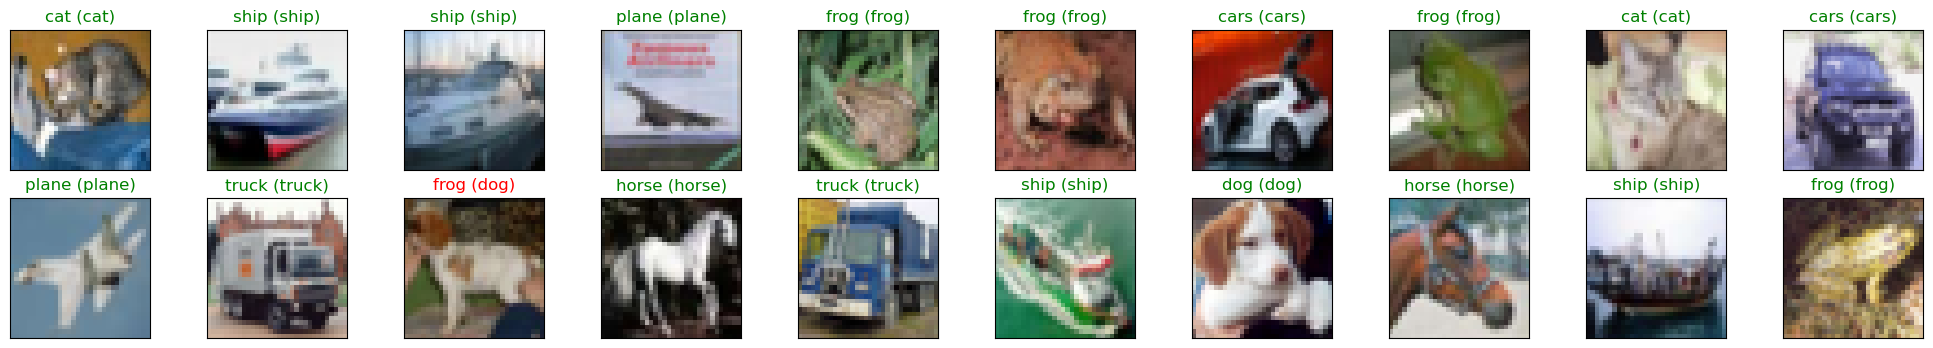

In [18]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images_ = images.to(device)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))

In [19]:
numeber_six = r"number six.jpg"
img = Image.open(numeber_six)
# img = ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img), cmap='gray')
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

FileNotFoundError: [Errno 2] No such file or directory: 'number six.jpg'